Load modules:

In [1]:
import pandas as pd
import numpy as np
import scanpy as sc
import sys
import os

sys.path.append("../../scripts/")
import reference_based_harmonizing
import seaborn as sns
import matplotlib.pyplot as plt
import sankey

For pretty code formatting:

In [2]:
%load_ext lab_black

set paths:

In [3]:
path_ct_df = "../../supporting_files/celltype_structure_and_colors/manual_anns_and_leveled_anns_ordered.csv"
path_adata = "../../data/HLCA_extended/HLCA_core_plus_single_study/HLCA_thienpont_2018_adata_full_tcnorm_log1p.h5ad"
path_ct_harmonizing = "../../supporting_files/metadata_harmonization/HLCA_cell_type_reference_mapping_20220915.csv"
dir_figures = "../../results/figures/"

load data and tables:

In [4]:
adata = sc.read_h5ad(path_adata)

In [5]:
ct_df = pd.read_csv(path_ct_df, index_col=0)

store the obs just for the thienpont data in a separate dataframe, for easy of calculations below:

In [6]:
adata_thienpont_obs = adata.obs.loc[adata.obs.study == "Thienpont_2018", :].copy()

remove prefixes from original annotations and transfered annotations:

In [7]:
# for original annotations
orig_ann_mapping = dict()
for orig_ann in adata_thienpont_obs.original_ann_level_5.unique():
    split_ann = orig_ann.split("_")
    if split_ann[0] in ["1", "2", "3", "4", "5"]:
        ann_no_prefix = "_".join(split_ann[1:])
    else:
        ann_no_prefix = orig_ann
    orig_ann_mapping[orig_ann] = ann_no_prefix

adata_thienpont_obs[
    "original_ann_level_5_no_prefix"
] = adata_thienpont_obs.original_ann_level_5.map(orig_ann_mapping)
# and transfered annotations:
transf_ann_mapping = dict()
for transf_ann in adata_thienpont_obs.transf_ann_level_5_label.unique():
    split_ann = transf_ann.split("_")
    if split_ann[0] in ["1", "2", "3", "4", "5"]:
        ann_no_prefix = "_".join(split_ann[1:])
    else:
        ann_no_prefix = transf_ann
    transf_ann_mapping[transf_ann] = ann_no_prefix

adata_thienpont_obs[
    "transf_ann_level_5_label_no_prefix"
] = adata_thienpont_obs.transf_ann_level_5_label.map(transf_ann_mapping)

we need our cell type reference to know the relations between possible finer annotations than our manual annotations (we did put them in the reference):

In [8]:
harmonizing_df = reference_based_harmonizing.load_harmonizing_table(path_ct_harmonizing)
consensus_df = reference_based_harmonizing.create_consensus_table(harmonizing_df)

## Label matching between query and reference

For each dataset, we need to clarify how the original annotations from the dataset match with the labels that we transferred from the atlas to the new data. (In that way we can check when the transfer was correct and when it wasn't).


In [9]:
original_to_transferred = {
    "Alveolar epithelium": [
        lev5ct.split("_")[-1]
        for lev2ct, lev5ct in zip(ct_df.Level_2, ct_df.Level_5)
        if lev2ct == "Alveolar epithelium"
    ],
    "B cell lineage": [
        lev5ct.split("_")[-1]
        for lev3ct, lev5ct in zip(ct_df.Level_3, ct_df.Level_5)
        if lev3ct == "B cell lineage"
    ],
    "Cancer": ["New"],
    "Endothelial": [
        lev5ct.split("_")[-1]
        for lev1ct, lev5ct in zip(ct_df.Level_1, ct_df.Level_5)
        if lev1ct == "Endothelial"
    ],
    "Epithelial": [
        lev5ct.split("_")[-1]
        for lev1ct, lev5ct in zip(ct_df.Level_1, ct_df.Level_5)
        if lev1ct == "Epithelial"
    ],
    "Erythroblast": ["New"],
    "Fibroblast lineage": [
        lev5ct.split("_")[-1]
        for lev1ct, lev5ct in zip(ct_df.Level_1, ct_df.Level_5)
        if lev1ct == "Stroma"
    ],  # they don't distinguish between stromal cells
    "Mast cells": ["Mast cells"],
    "Myeloid": [
        lev5ct.split("_")[-1]
        for lev2ct, lev5ct in zip(ct_df.Level_2, ct_df.Level_5)
        if lev2ct == "Myeloid"
    ],
    "T cell lineage": [
        lev5ct.split("_")[-1]
        for lev3ct, lev5ct in zip(ct_df.Level_3, ct_df.Level_5)
        if lev3ct in ["T cell lineage", "Innate lymphoid cell NK"]
    ],  # these are also NK cells
}

Now add a column to our transfer res and (further below) adata, that has cell type annotations to use for the label transfer figures. We will include corrected labels here, as in the cell above:

In [10]:
query_to_figure_label = {
    ct: ct for ct in adata_thienpont_obs.original_ann_level_5_no_prefix
}
query_to_figure_label["Fibroblast lineage"] = "Stroma"
query_to_figure_label["T cell lineage"] = "T/NK cells"

In [11]:
adata_thienpont_obs["original_ann_for_label_tr_fig"] = pd.Categorical(
    adata_thienpont_obs.original_ann_level_5_no_prefix.map(
        query_to_figure_label
    ).astype(str)
)

calculate evaluation (correct or incorrect label transfer):

In [12]:
adata_thienpont_obs["label_tr_evaluation"] = "Incorrect"
for ct, correct_labels in original_to_transferred.items():
    cells_to_evaluate_correct = adata_thienpont_obs.loc[
        (adata_thienpont_obs.original_ann_level_5_no_prefix == ct)
        & (adata_thienpont_obs.transf_ann_level_5_label_no_prefix.isin(correct_labels)),
        :,
    ].index
    adata_thienpont_obs.loc[
        cells_to_evaluate_correct, "label_tr_evaluation"
    ] = "Correct"

add thresholded columns, to set cells with uncertainty > threshold to "Unknown":

In [13]:
unc_thresh = 0.3
adata_thienpont_obs[
    "label_tr_evaluation_thresholded"
] = adata_thienpont_obs.label_tr_evaluation.tolist()
adata_thienpont_obs[
    "transf_ann_level_5_label_no_prefix_thresholded"
] = adata_thienpont_obs.transf_ann_level_5_label_no_prefix.tolist()
adata_thienpont_obs.loc[
    adata_thienpont_obs.transf_ann_level_5_uncert > unc_thresh,
    "label_tr_evaluation_thresholded",
] = "Unknown"
adata_thienpont_obs.loc[
    adata_thienpont_obs.transf_ann_level_5_uncert > unc_thresh,
    "transf_ann_level_5_label_no_prefix_thresholded",
] = "Unknown"

In [14]:
adata_thienpont_obs.label_tr_evaluation.value_counts()

Correct      78624
Incorrect    14951
Name: label_tr_evaluation, dtype: int64

In [15]:
print(unc_thresh)
print("Evaluation counts:")
print(adata_thienpont_obs.label_tr_evaluation_thresholded.value_counts())
print("\nEvaluation percentages:")
print(
    round(
        adata_thienpont_obs.label_tr_evaluation_thresholded.value_counts()
        / adata_thienpont_obs.shape[0]
        * 100,
        0,
    )
)

0.3
Evaluation counts:
Correct      62105
Unknown      26037
Incorrect     5433
Name: label_tr_evaluation_thresholded, dtype: int64

Evaluation percentages:
Correct      66.0
Unknown      28.0
Incorrect     6.0
Name: label_tr_evaluation_thresholded, dtype: float64


some more stats for lambrechts data:

In [16]:
non_new_cells = adata_thienpont_obs.index[
    ~adata_thienpont_obs.original_ann_for_label_tr_fig.isin(["Erythroblast", "Cancer"])
]
print("Evaluation of non-erythroblast, non-cancer cells (percentages):")
print(
    adata_thienpont_obs.loc[
        non_new_cells, "label_tr_evaluation_thresholded"
    ].value_counts()
    / len(non_new_cells)
    * 100
)

Evaluation of non-erythroblast, non-cancer cells (percentages):
Correct      76.797992
Unknown      21.944403
Incorrect     1.257605
Name: label_tr_evaluation_thresholded, dtype: float64


add results to adata:

In [17]:
for obs in [
    "original_ann_level_5_no_prefix",
    "transf_ann_level_5_label_no_prefix",
    "original_ann_for_label_tr_fig",
    "label_tr_evaluation",
    "label_tr_evaluation_thresholded",
    "transf_ann_level_5_label_no_prefix_thresholded",
]:
    adata.obs[obs] = np.nan
    adata.obs.loc[adata_thienpont_obs.index, obs] = adata_thienpont_obs[obs]

add data source info to adata:

In [18]:
adata.obs["HLCA_or_query"] = "HLCA core"
adata.obs.loc[
    adata.obs.study == "Thienpont_2018", "HLCA_or_query"
] = "New data (lung cancer)"

## plot label transfer results:

In [19]:
FIGURES = dict()

In [20]:
sc.set_figure_params(dpi=140)

randomize order of adata for objective plotting:

In [21]:
new_order = adata.obs.index.tolist()
np.random.shuffle(new_order)

In [22]:
adata = adata[new_order, :]

get celltype plotting order, and colors (for ref) for reference and query labels:

In [23]:
# for ref
cts_core = ct_df.index.tolist()
ct2col_ref = {ct: col for ct, col in zip(ct_df.index, ct_df.colors)}
ct2col_ref["Unknown"] = "#959595"
ct2col_ref["nan"] = "#959595"
# for query:
cts_q = adata_thienpont_obs.original_ann_for_label_tr_fig.unique()
cts_q_rank = pd.DataFrame(index=cts_q, columns=["rank"])
cts_q_rank.index.name = "celltype"
for ct in cts_q:
    corresponding_rows = np.where(
        [ct in ct_df.loc[ref_ct_row, :].values for ref_ct_row in ct_df.index]
    )[0]
    if len(corresponding_rows) == 0:
        cts_q_rank.loc[
            ct, "rank"
        ] = 1000  # artificially high so that new cts will be sorted to the end
    else:
        cts_q_rank.loc[ct, "rank"] = corresponding_rows[0]
ct_df_q = cts_q_rank.sort_values(by=["rank", "celltype"]).index.tolist()

/home/icb/lisa.sikkema/miniconda3/envs/HLCA_basic/lib/python3.7/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/icb/lisa.sikkema/miniconda3/envs/HLCA_basic/lib/python3.7/contextlib.py:119: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  next(self.gen)


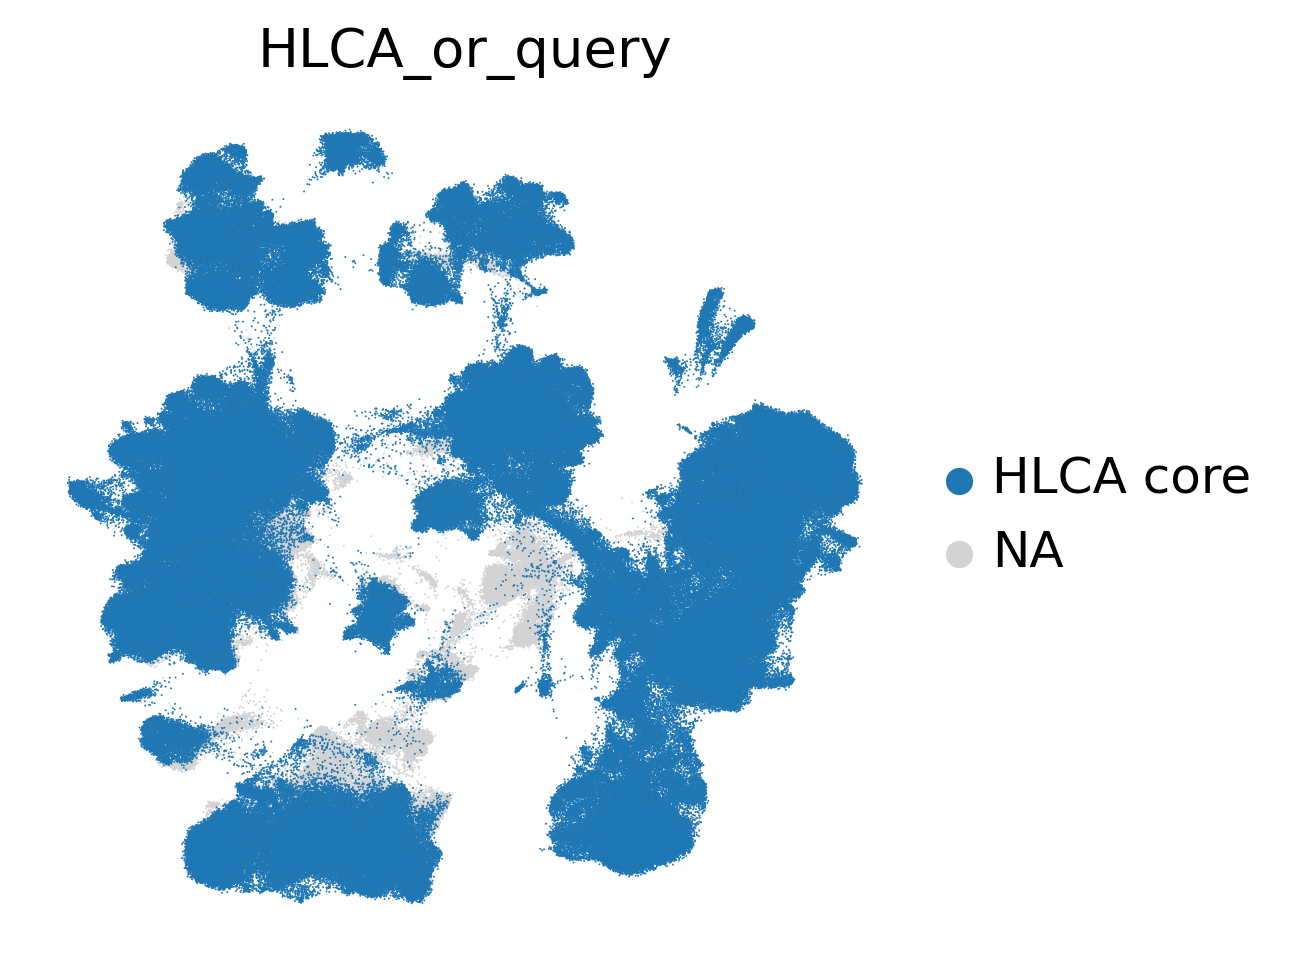

In [24]:
colors_ref_vs_q = {
    "HLCA core": "tab:blue",
    "New data (lung cancer)": "tab:orange",
}
FIGURES[f"ED_thienpont_umap_ref_vs_q_ref"] = sc.pl.umap(
    adata,
    color="HLCA_or_query",
    groups="HLCA core",
    s=1,
    frameon=False,
    return_fig=True,
    sort_order=True,
    palette=colors_ref_vs_q,
)

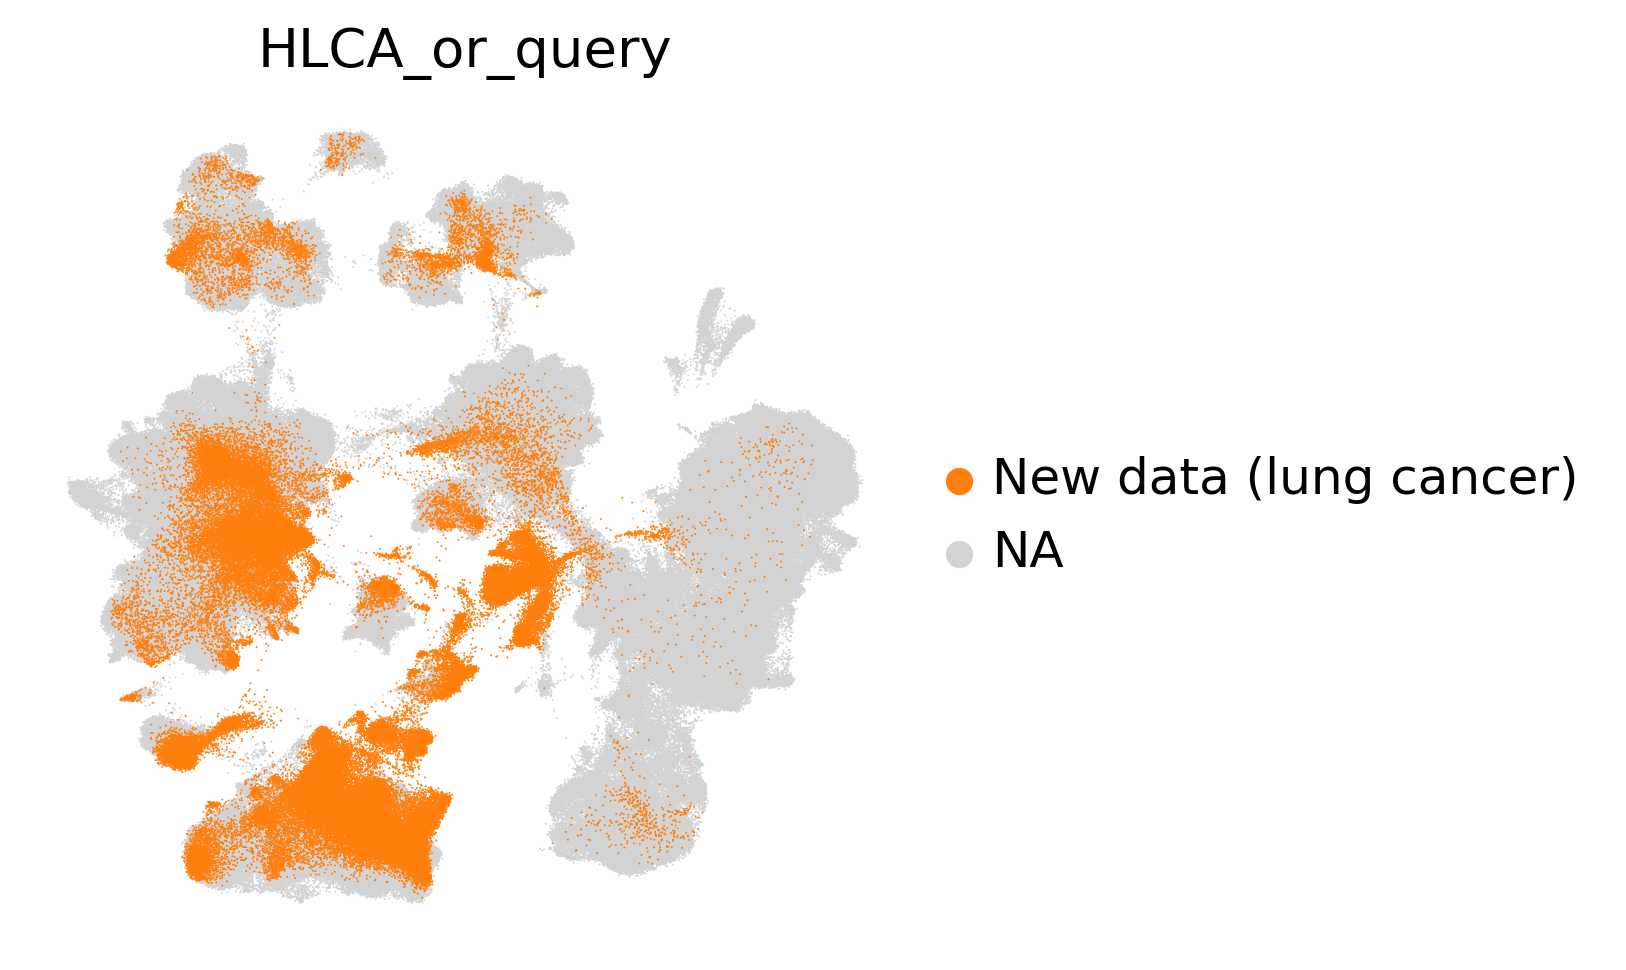

In [25]:
FIGURES["ED_thienpont_umap_ref_vs_q_query"] = sc.pl.umap(
    adata,
    color="HLCA_or_query",
    groups="New data (lung cancer)",
    s=1,
    frameon=False,
    return_fig=True,
    sort_order=True,
    palette=colors_ref_vs_q,
)

as per reviewers request, a Seurat splitby version of the two umaps above:

In [26]:
colors_ref_vs_q_splitby1 = {"HLCA core": "tab:blue", "New data (lung cancer)": "white"}
colors_ref_vs_q_splitby2 = {
    "HLCA core": "white",
    "New data (lung cancer)": "tab:orange",
}

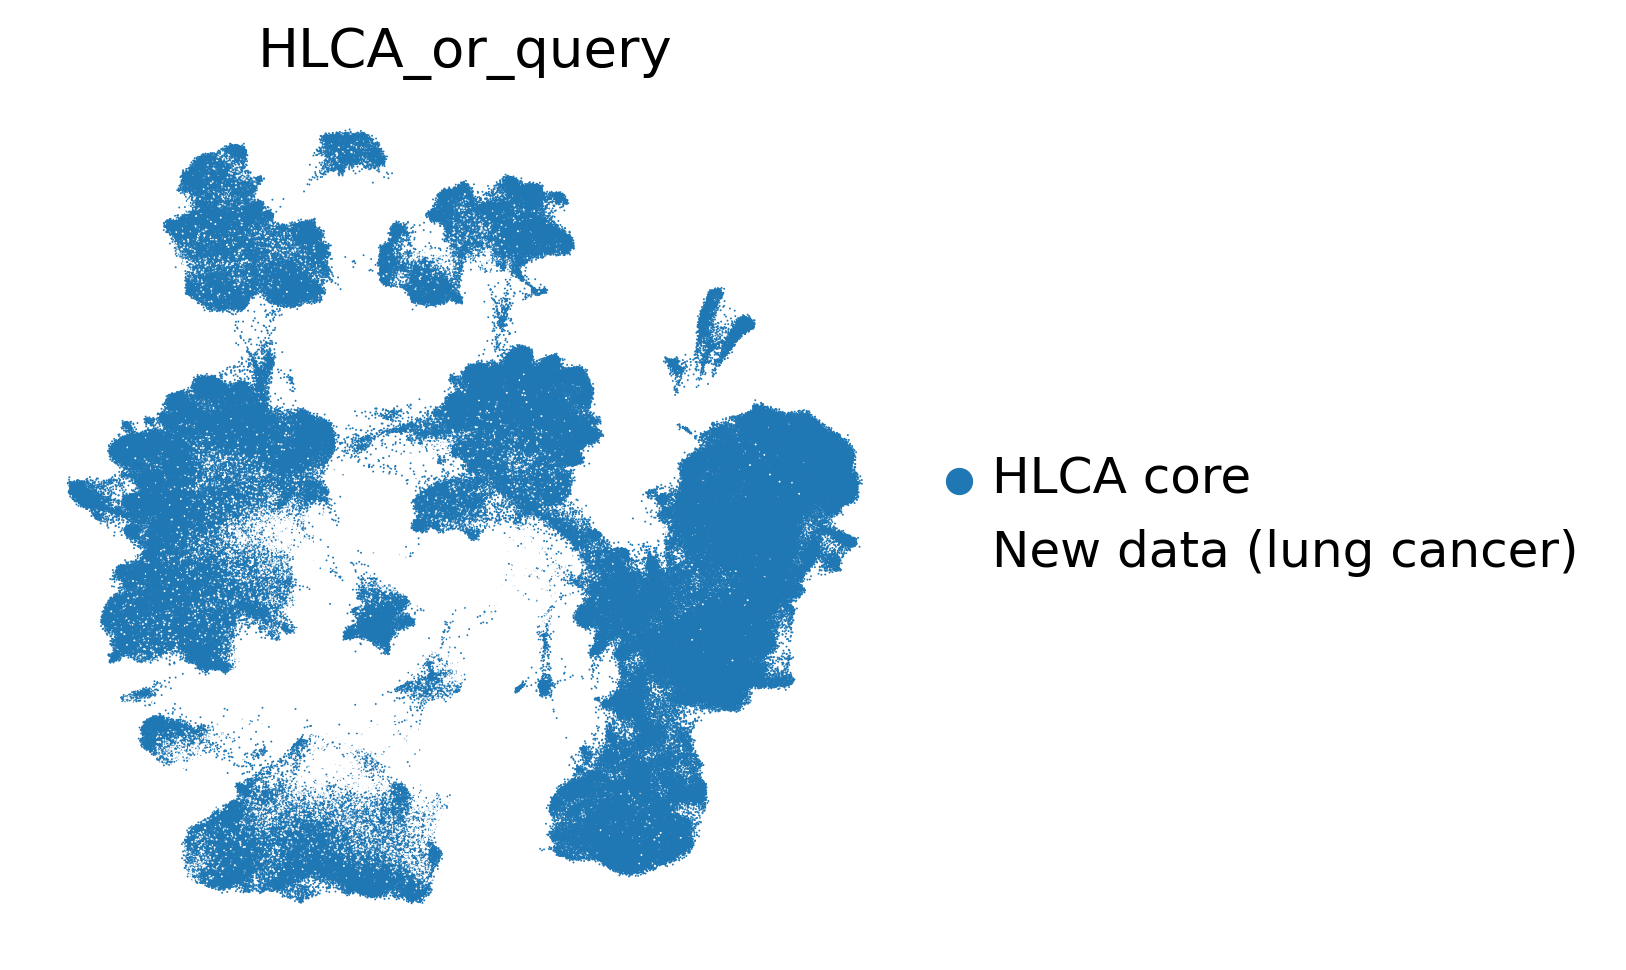

In [27]:
FIGURES["ED_thienpont_umap_ref_vs_q_ref_splitby"] = sc.pl.umap(
    adata,
    color="HLCA_or_query",
    s=1,
    frameon=False,
    return_fig=True,
    sort_order=True,
    palette=colors_ref_vs_q_splitby1,
)

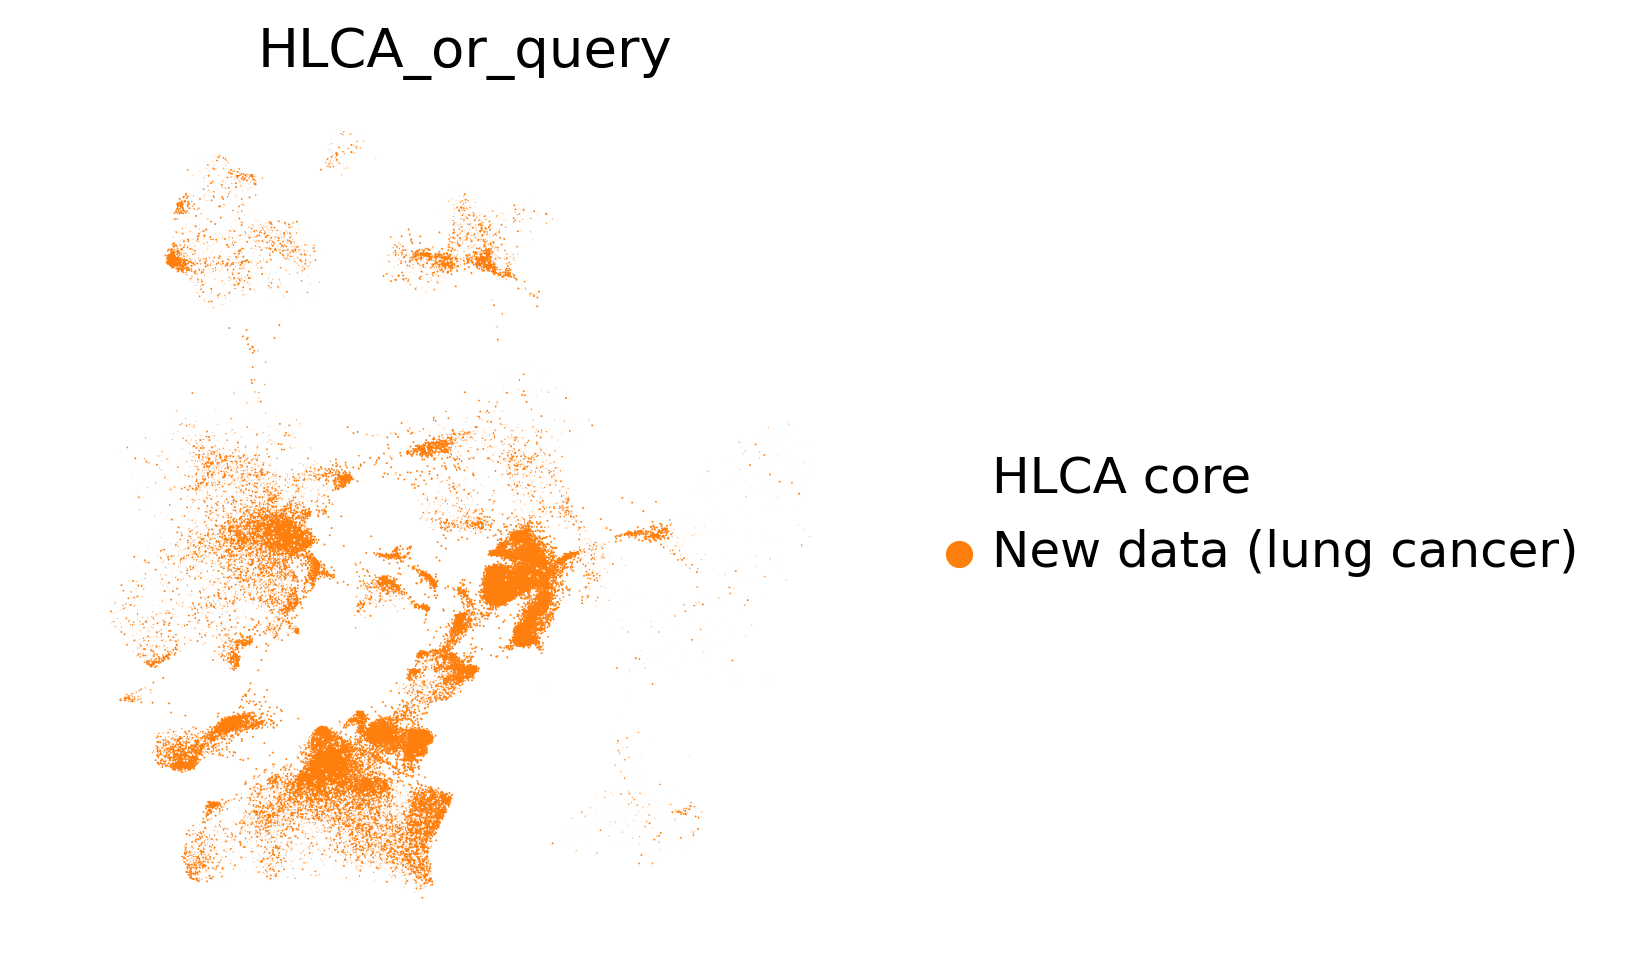

In [28]:
FIGURES["ED_thienpont_umap_ref_vs_q_q_splitby"] = sc.pl.umap(
    adata,
    color="HLCA_or_query",
    s=1,
    frameon=False,
    return_fig=True,
    sort_order=True,
    palette=colors_ref_vs_q_splitby2,
)

Clean up and order manual ann, to correspond to rest of paper (also colors):

In [29]:
# set manual ann NA to np.nan, so that we can color it black in the scanpy function below
adata.obs.loc[adata.obs.manual_ann == "nan", "manual_ann"] = np.nan
adata.obs.loc[pd.isnull(adata.obs.manual_ann).values, "manual_ann"] = np.nan
adata.obs.manual_ann = adata.obs.manual_ann.cat.remove_unused_categories()

In [30]:
adata.obs["manual_ann"] = adata.obs["manual_ann"].cat.reorder_categories(
    new_categories=ct_df.index
)

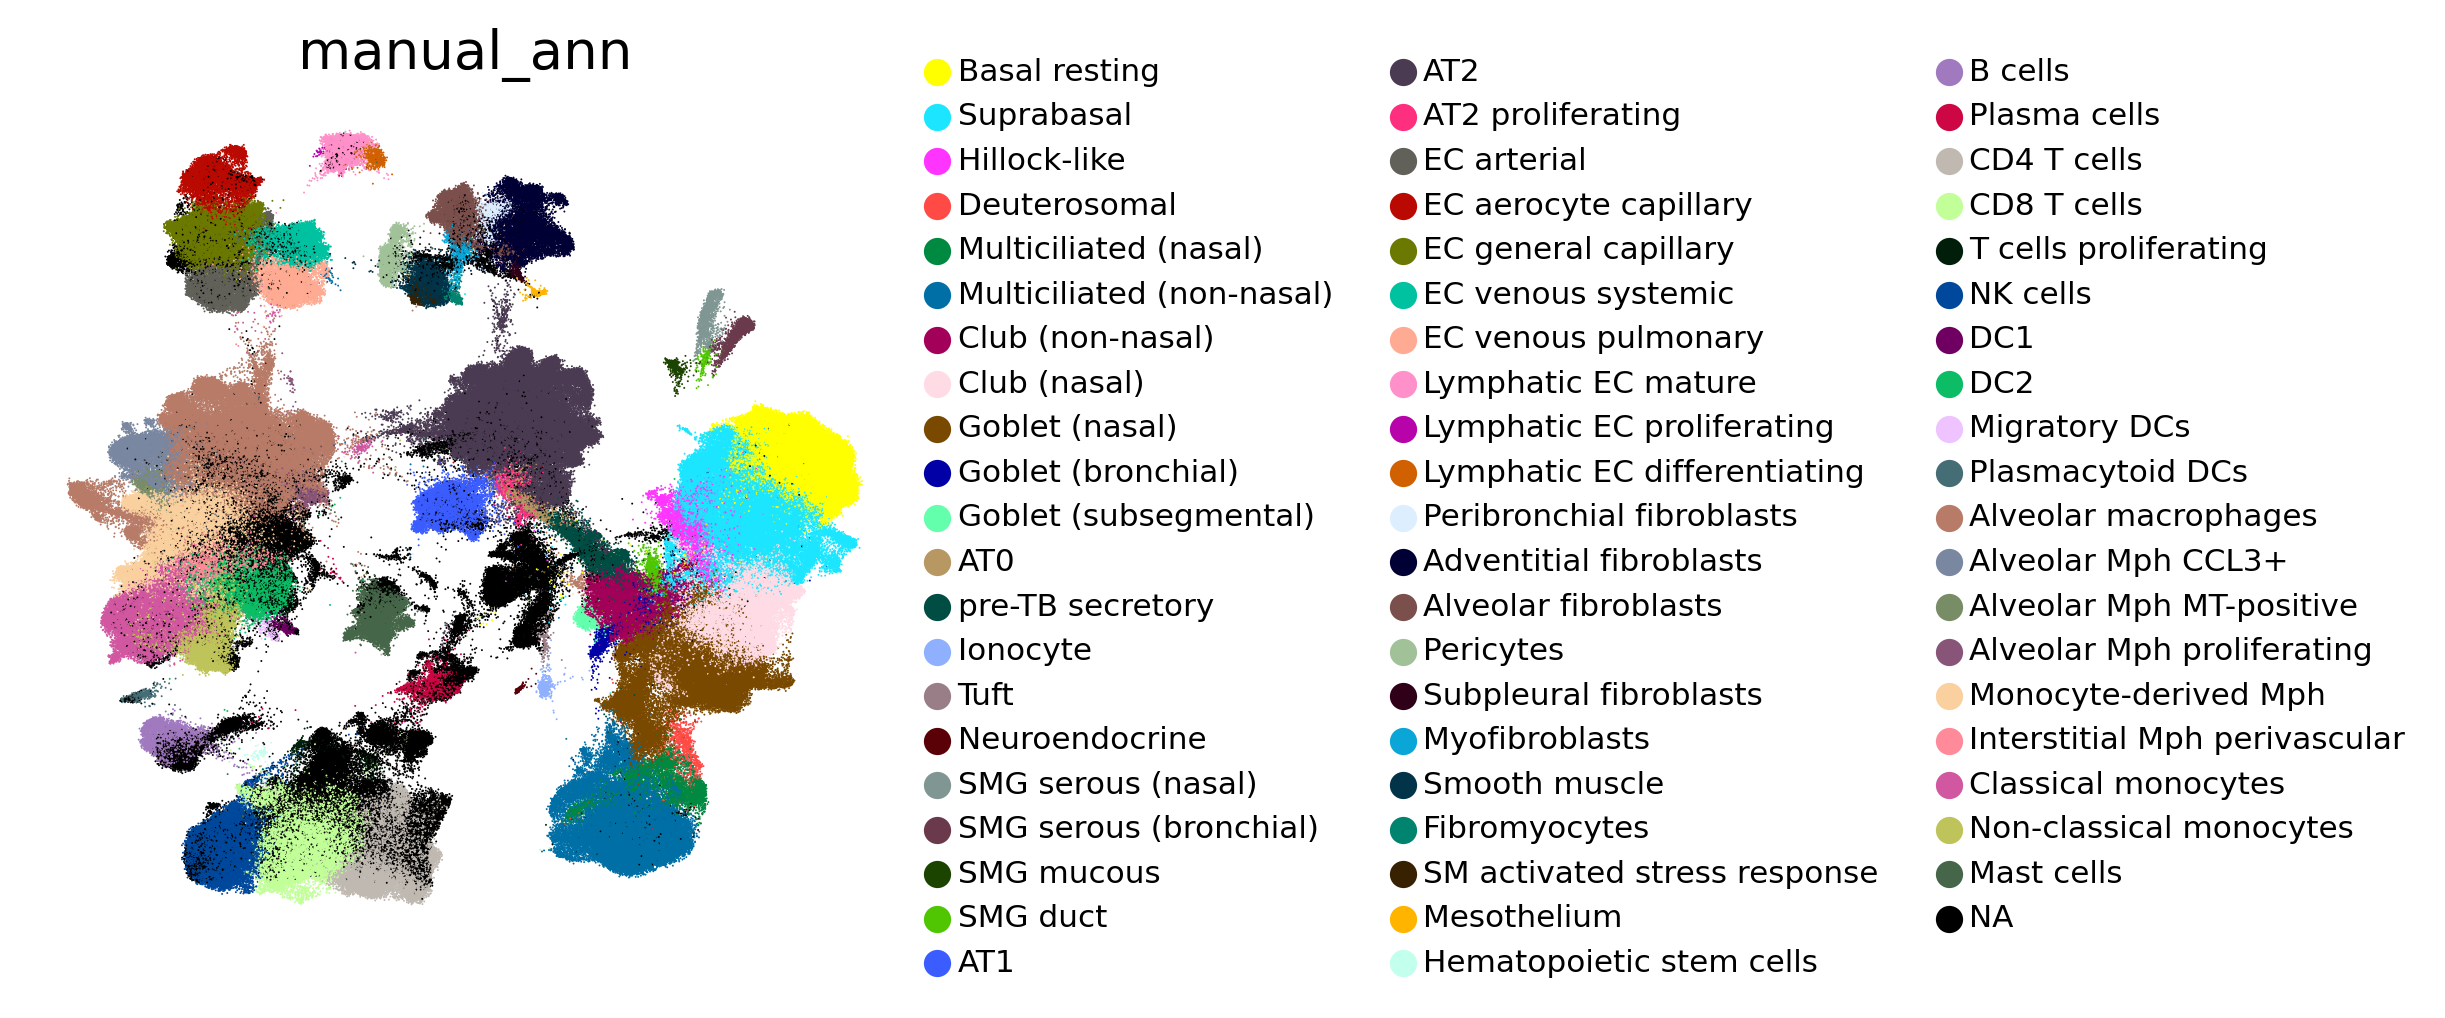

In [31]:
FIGURES["ED_thienpont_umap_core_anns"] = sc.pl.umap(
    adata,
    color=["manual_ann"],
    s=1,
    frameon=False,
    return_fig=True,
    sort_order=False,
    na_color="black",
    palette=ct2col_ref,
    legend_fontsize=8,
)

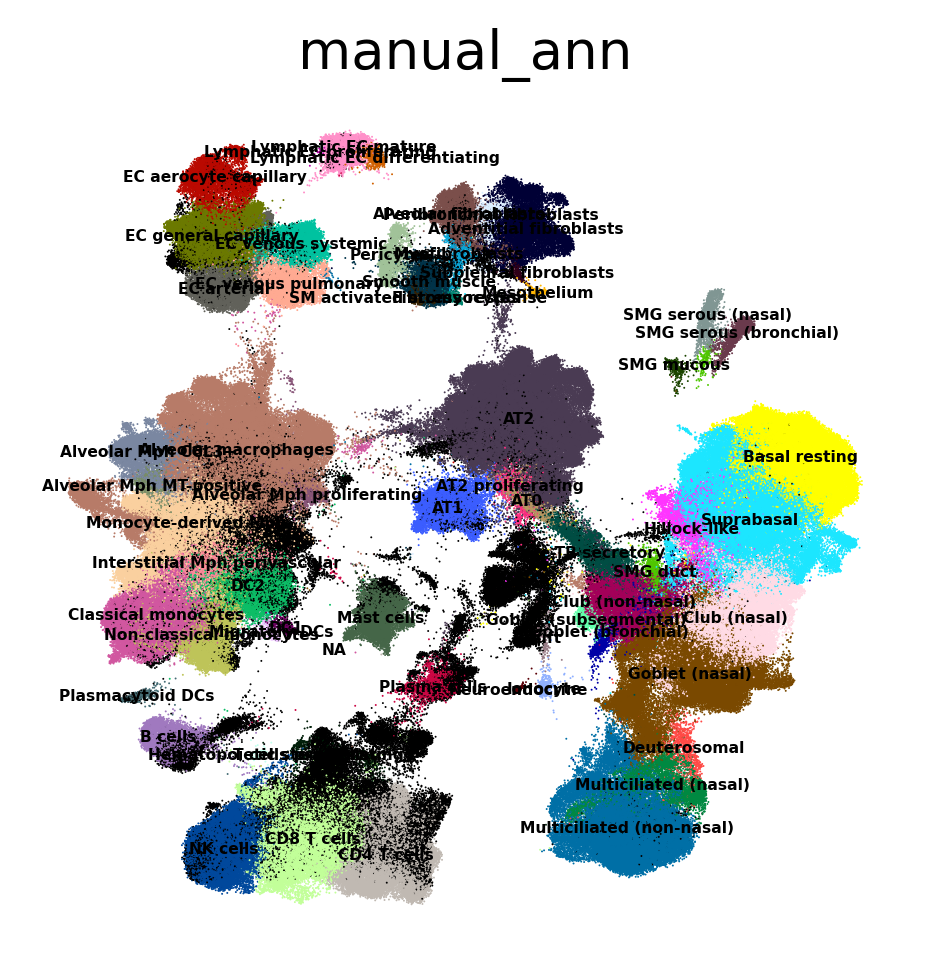

In [32]:
FIGURES["ED_thienpont_umap_core_anns_labels_on_top"] = sc.pl.umap(
    adata,
    color=["manual_ann"],
    s=1,
    frameon=False,
    return_fig=True,
    sort_order=False,
    na_color="black",
    palette=ct2col_ref,
    legend_fontsize=4,
    legend_loc="on data",
)

create a sorted embedding, such that cells from HLCA come first and rest comes after (but is mixed). This will ensure that HLCA cells are plotted on the bottom

In [33]:
HLCA_cells = adata.obs.index[adata.obs.HLCA_or_query == "HLCA core"].tolist()
query_cells = adata.obs.index[adata.obs.HLCA_or_query != "HLCA core"].tolist()

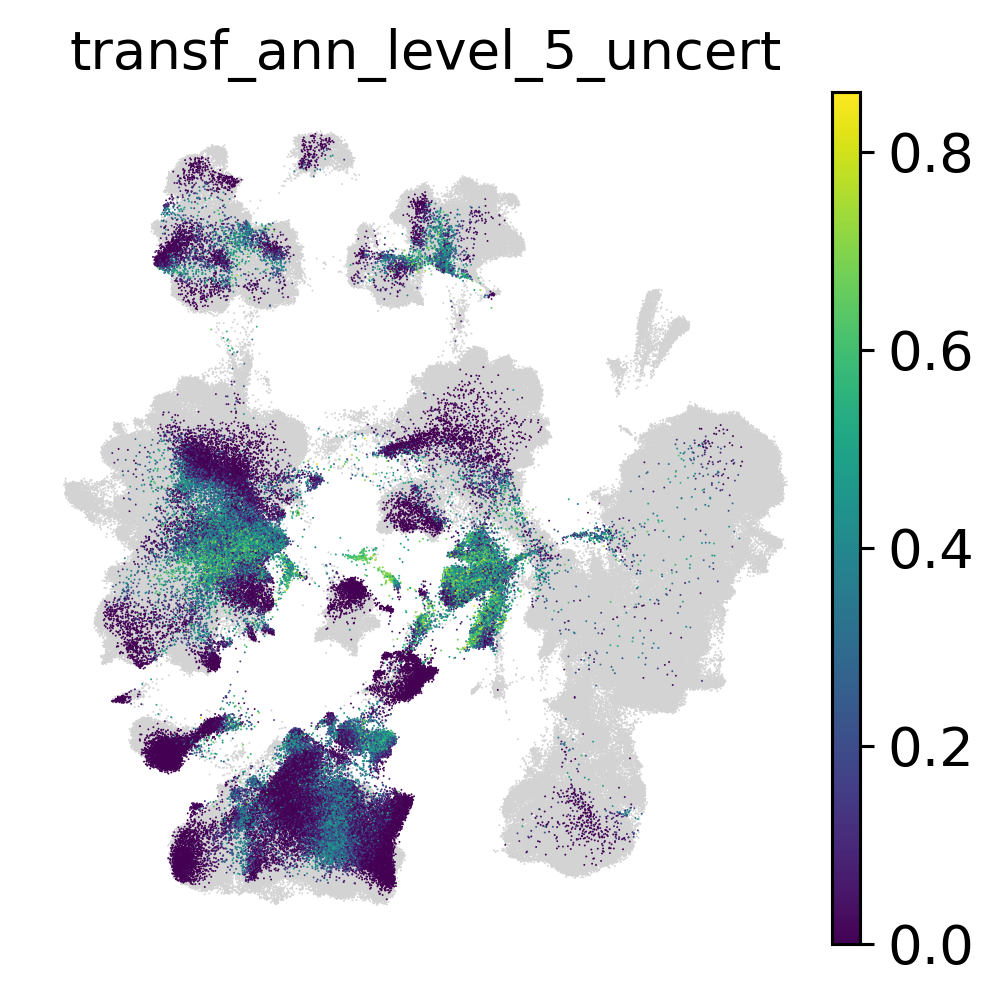

In [34]:
FIGURES[f"ED_thienpont_umap_uncert"] = sc.pl.umap(
    adata[HLCA_cells + query_cells, :],
    color=["transf_ann_level_5_uncert"],
    s=1,
    frameon=False,
    return_fig=True,
    sort_order=False,
)

/home/icb/lisa.sikkema/miniconda3/envs/HLCA_basic/lib/python3.7/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


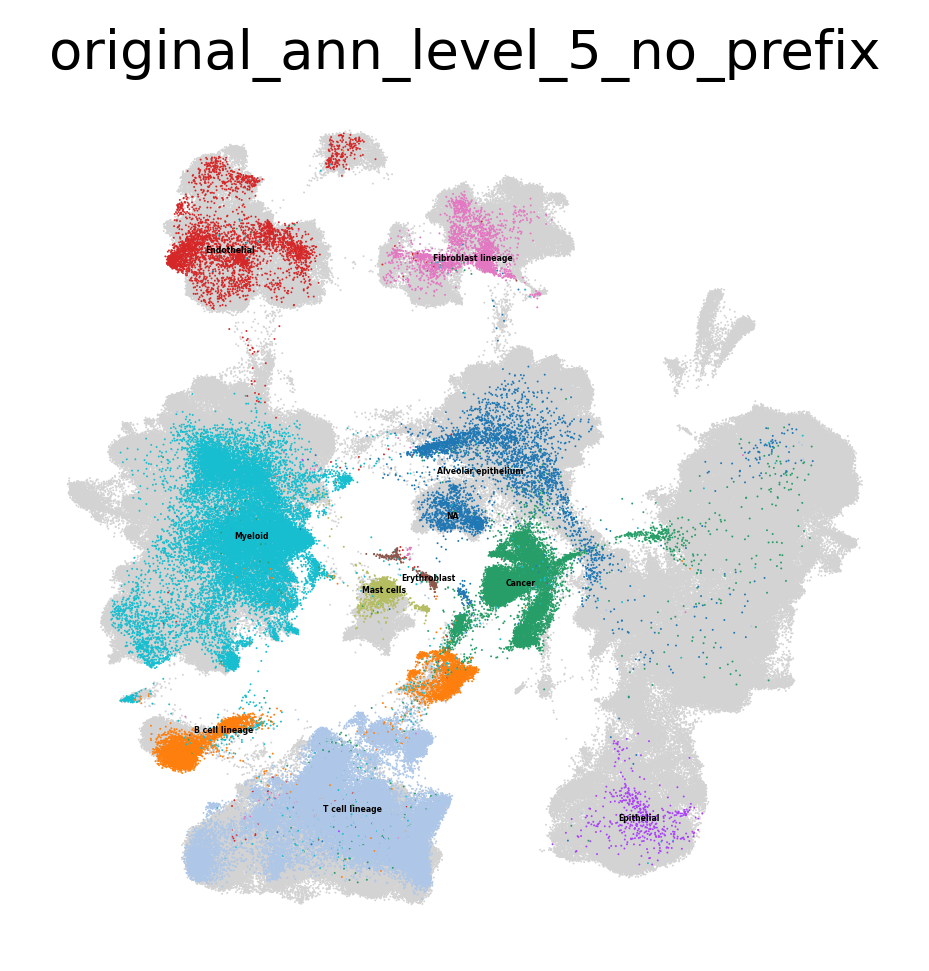

In [35]:
FIGURES[f"ED_thienpont_umap_query_orig_labels"] = sc.pl.umap(
    adata[HLCA_cells + query_cells, :],
    color=["original_ann_level_5_no_prefix"],
    s=1,
    frameon=False,
    return_fig=True,
    sort_order=False,
    legend_loc="on data",
    legend_fontsize=2,
)

order figure cell type labels based on hierarchical reference:

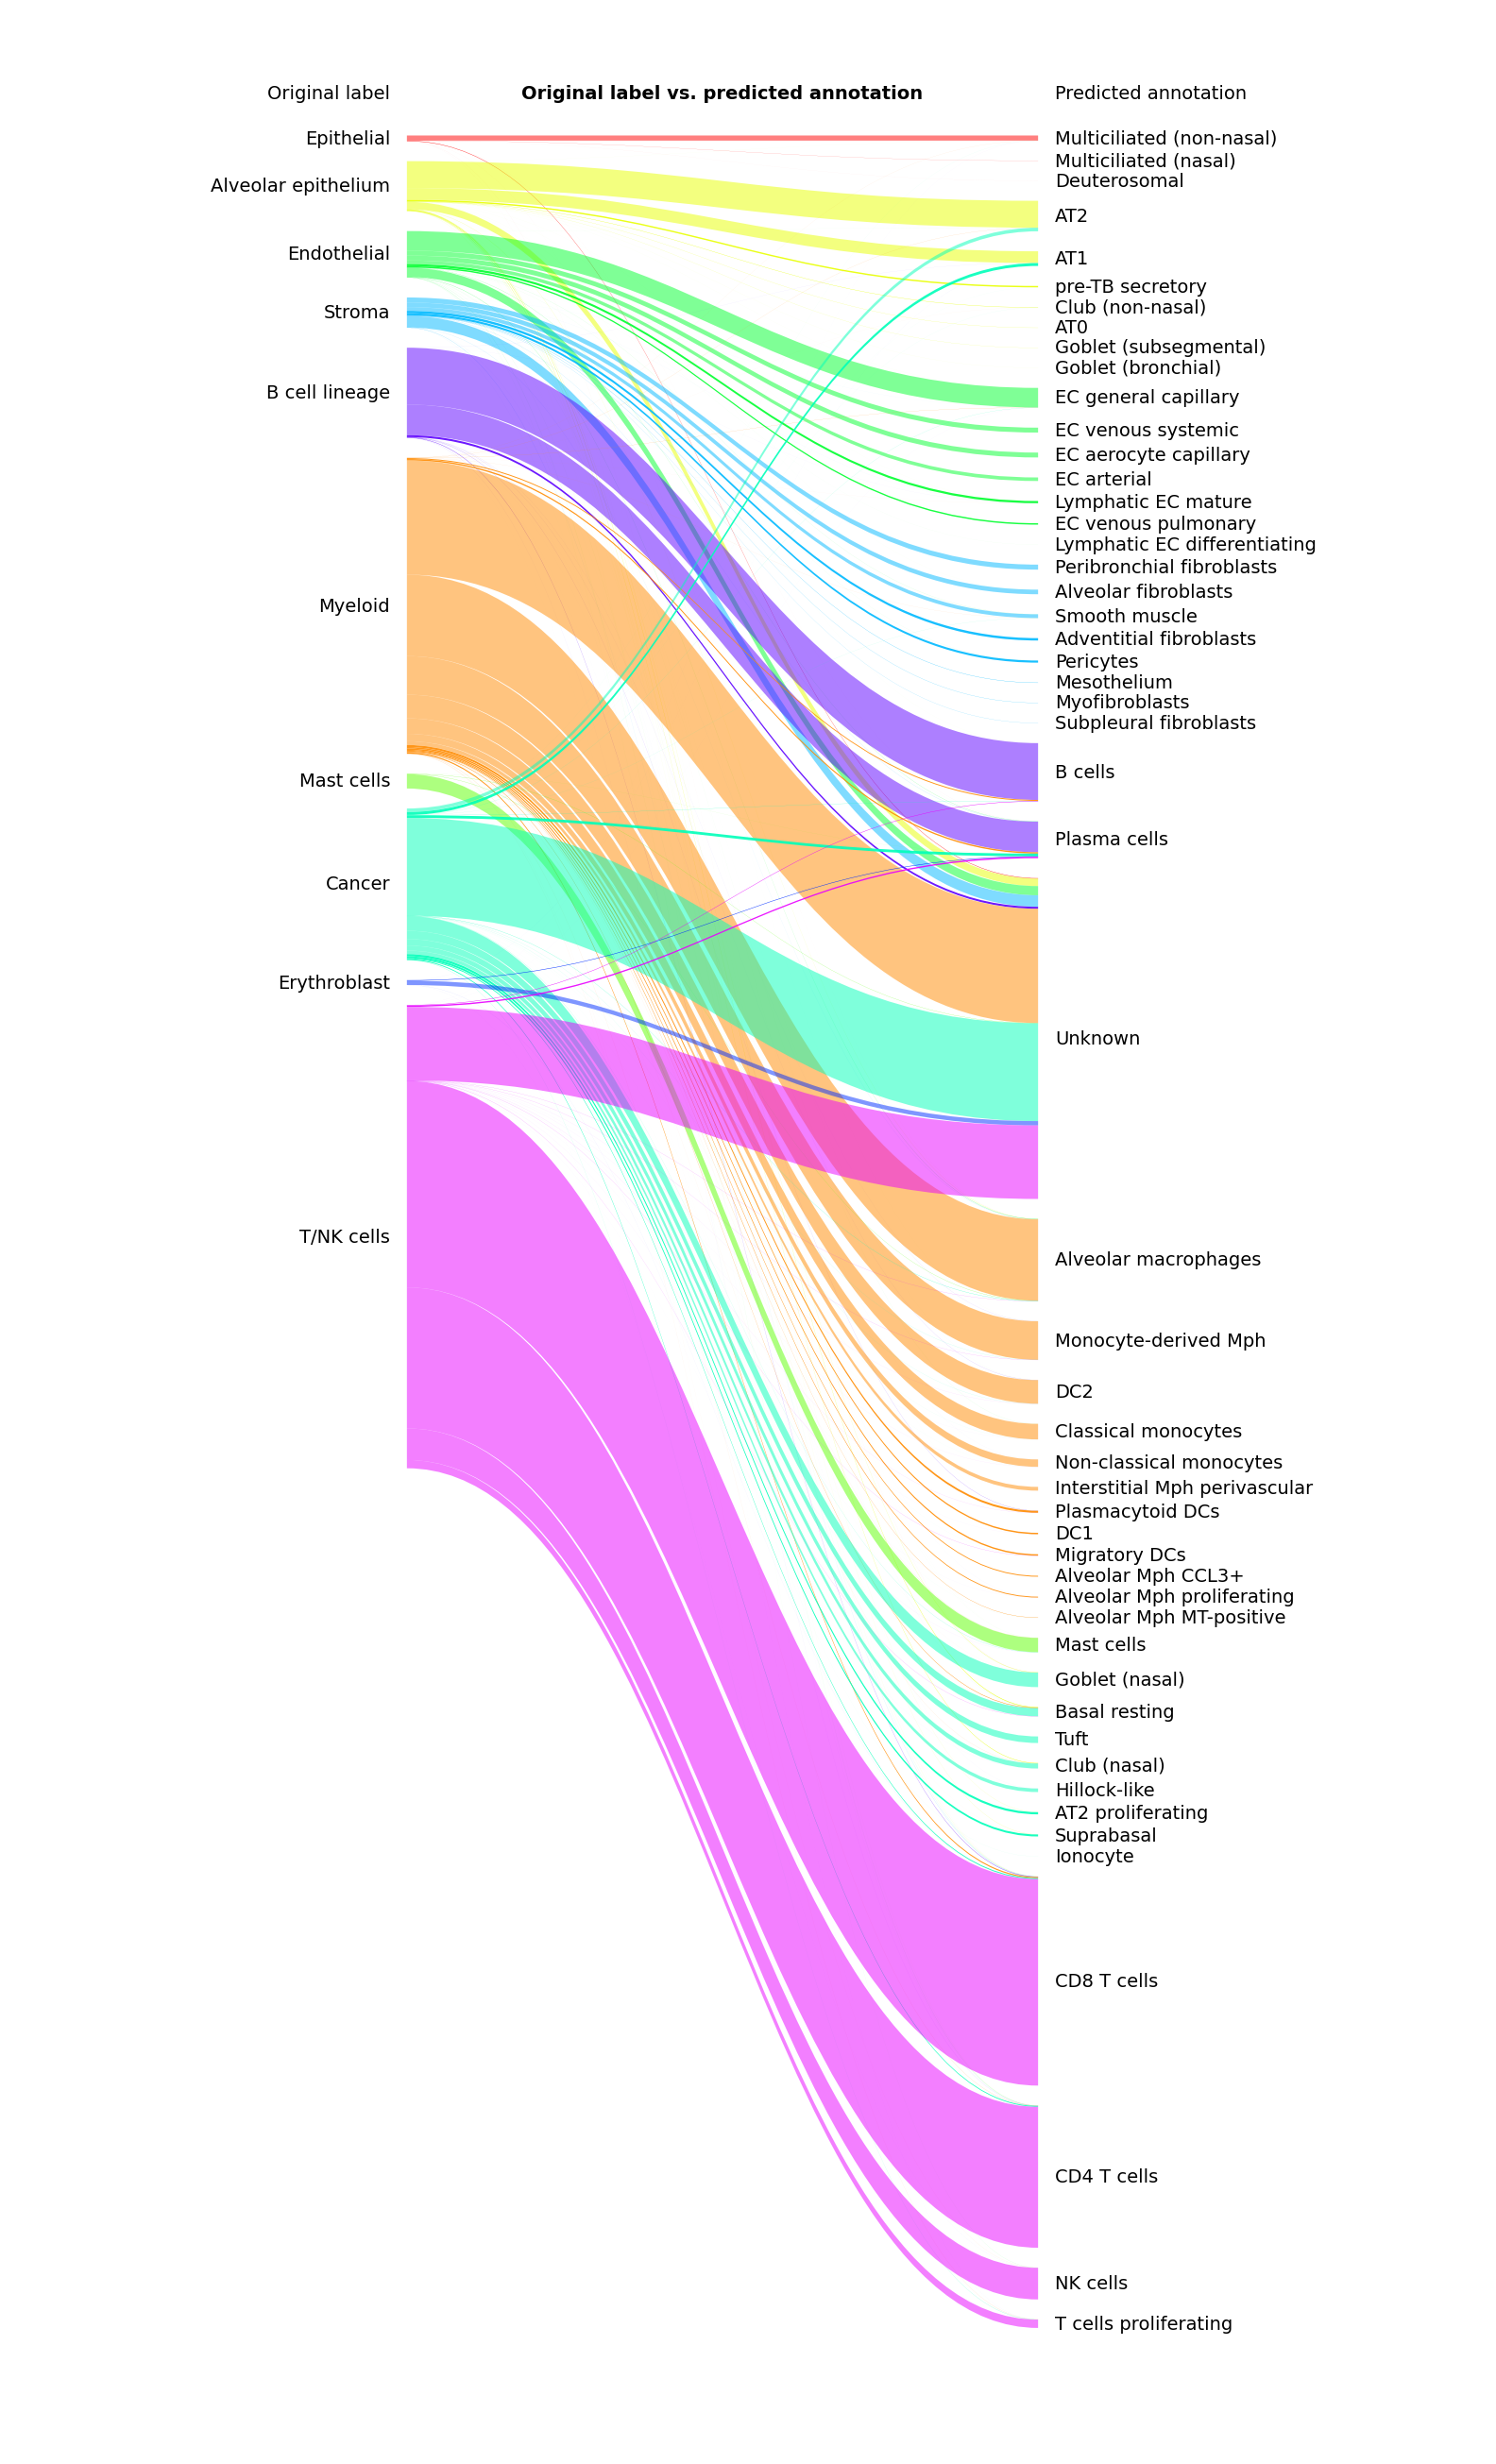

In [36]:
fig, ax = plt.subplots(figsize=(7, 12))
sankey.sankey(
    x=adata_thienpont_obs.original_ann_for_label_tr_fig,
    y=adata_thienpont_obs.transf_ann_level_5_label_no_prefix_thresholded,
    title="Original label vs. predicted annotation",
    title_left="Original label",
    title_right="Predicted annotation",
    ax=ax,
    fontsize="5",  # "xx-small",
    left_order=ct_df_q,
    #     colors=ct2co[query_adata_name],
    alpha=0.5,
)
plt.show()
plt.close()
FIGURES[f"ED_thienpont_label_transfer_sankey_plot"] = fig

In [37]:
custom_palette_unseen = dict()
new_cts = ["Cancer", "Erythroblast"]
for ct in adata_thienpont_obs.original_ann_for_label_tr_fig.unique():
    if ct in new_cts:
        custom_palette_unseen[ct] = "tab:red"
    else:
        custom_palette_unseen[ct] = "lightgrey"

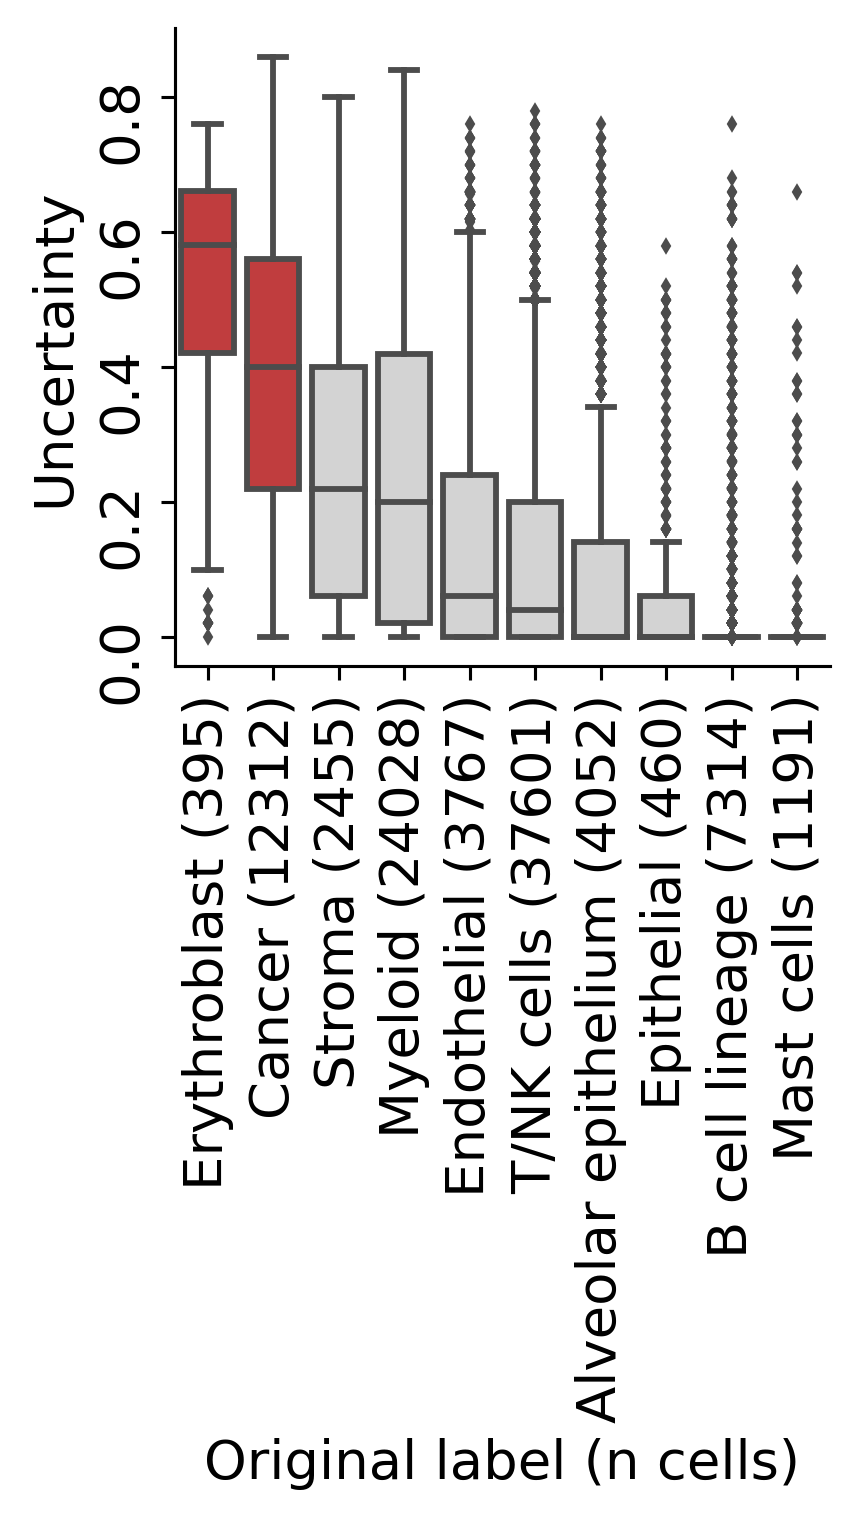

In [38]:
incl_celln_in_label = True
ct_order = (
    adata_thienpont_obs.groupby("original_ann_for_label_tr_fig")
    .agg({"transf_ann_level_5_uncert": "median"})
    .sort_values(by="transf_ann_level_5_uncert", ascending=False)
    .index.tolist()
)
with plt.rc_context(
    {
        "figure.figsize": (0.3 * len(ct_order), 3),
        "axes.spines.right": False,
        "axes.spines.top": False,
    }
):
    fig, ax = plt.subplots()
    x = adata_thienpont_obs.original_ann_for_label_tr_fig
    sns.boxplot(
        x=x,
        y=adata_thienpont_obs.transf_ann_level_5_uncert,
        palette=custom_palette_unseen,
        ax=ax,
        fliersize=2,
        order=ct_order,
    )
    ax.tick_params(rotation=90)
    if incl_celln_in_label:
        total_n_per_ct = (
            adata_thienpont_obs.original_ann_for_label_tr_fig.value_counts()
        )
        cts_no_underscore = [ct.replace("_", " ") for ct in ct_order]
        ax.set_xticklabels(
            [
                f"{ct_no_und} ({total_n_per_ct[ct]})"
                for ct_no_und, ct in zip(cts_no_underscore, ct_order)
            ],
        )
        ax.set_xlabel("Original label (n cells)")
    else:
        ax.set_xticklabels([ct.replace("_", " ") for ct in ct_order])
        ax.set_xlabel("Original label")
    ax.set_ylabel("Uncertainty")
    plt.grid(False)
    plt.show()
    FIGURES["ED_thienpont_lab_tr_uncert_per_ct_boxplot"] = fig

uncertainty by *predicted* annotation:

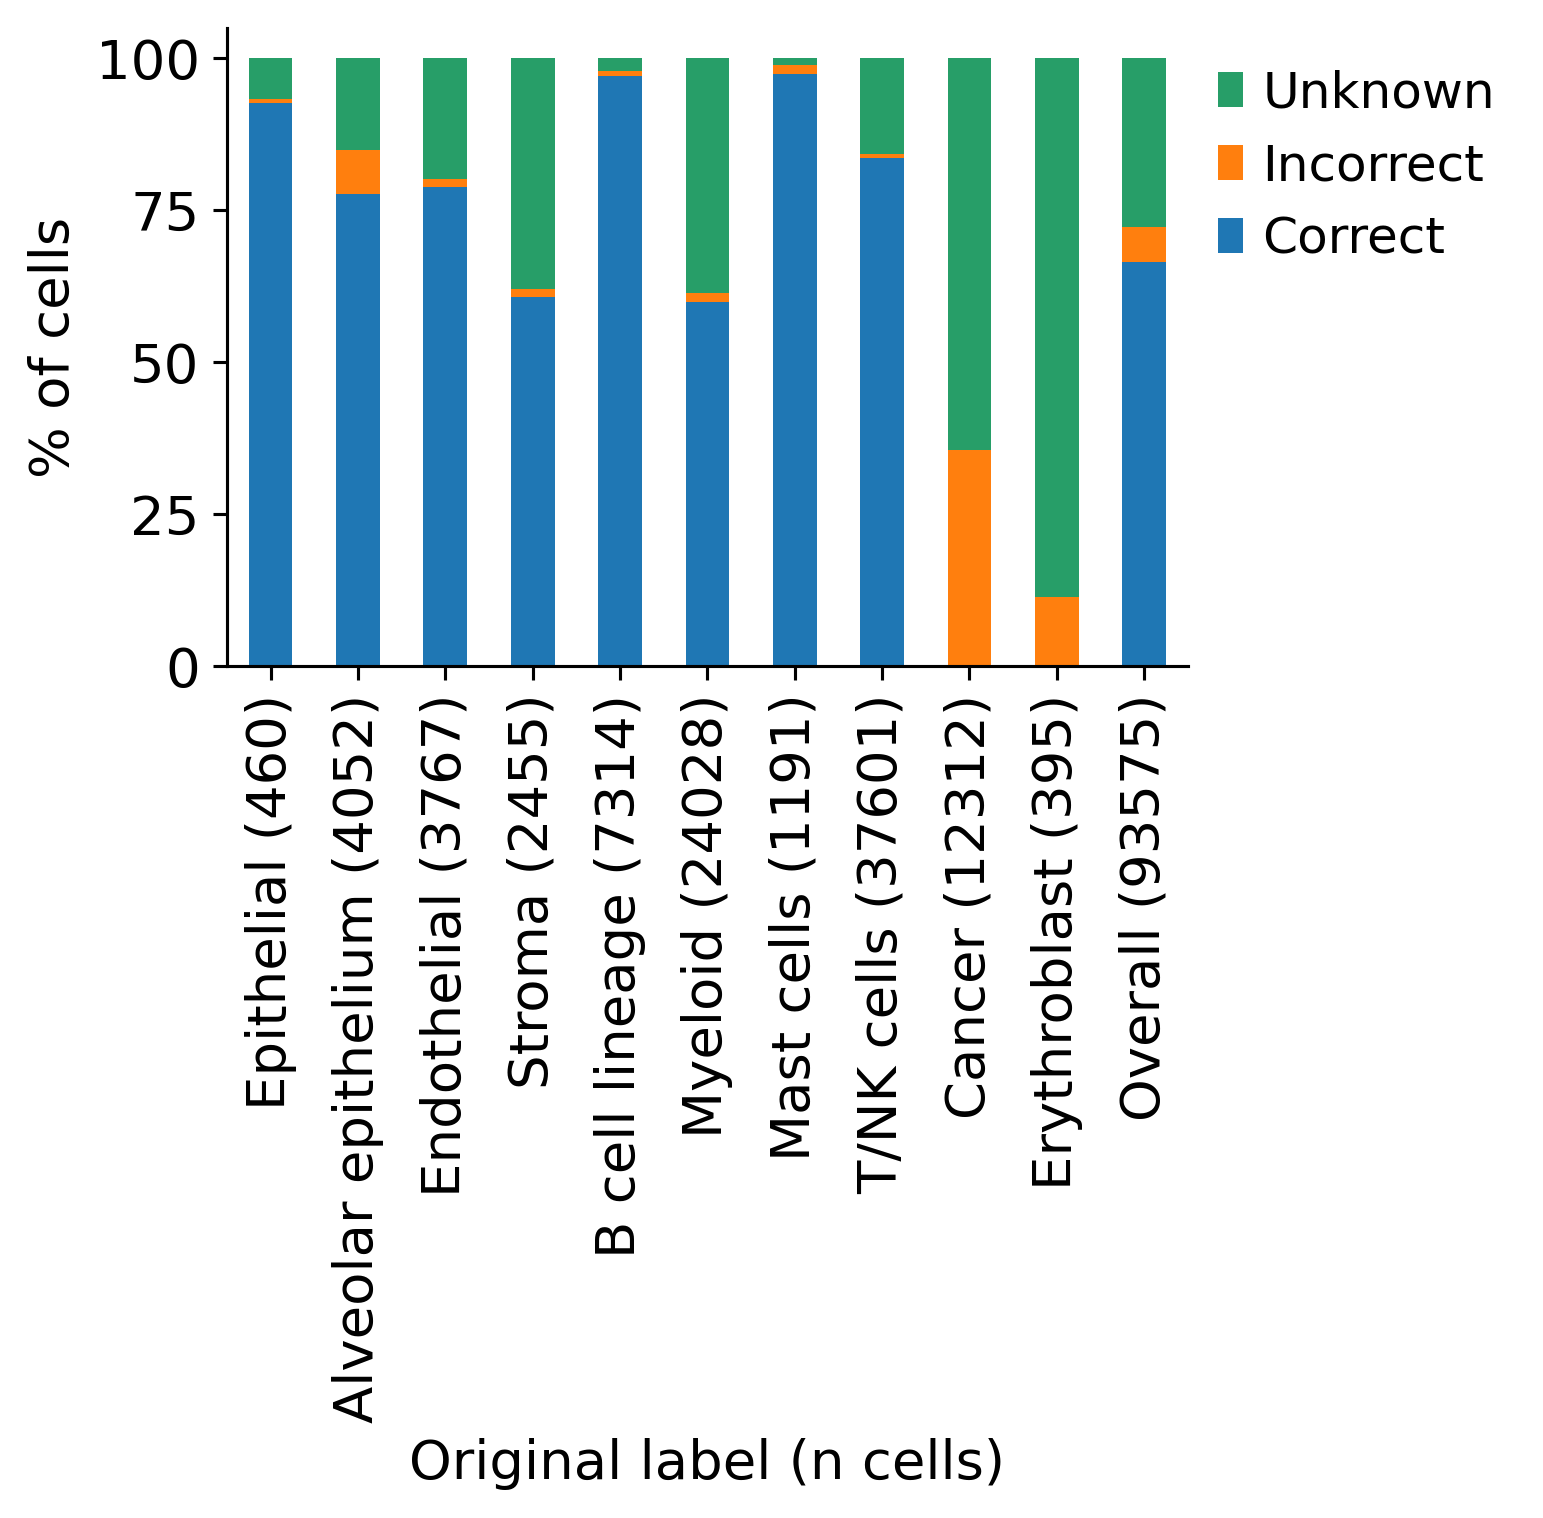

In [39]:
perc_correct = pd.crosstab(
    adata_thienpont_obs.original_ann_for_label_tr_fig,
    adata_thienpont_obs.label_tr_evaluation_thresholded,
).loc[ct_df_q, :]
total_n_per_ct = adata_thienpont_obs.original_ann_for_label_tr_fig.value_counts()
perc_correct = perc_correct.div(perc_correct.sum(axis=1), axis="rows") * 100
# add a bar (=row) for the entire query dataset:
perc_correct.index = perc_correct.index.tolist()
total_n_per_ct.index = total_n_per_ct.index.tolist()
total_n_per_ct["Overall"] = adata_thienpont_obs.shape[0]
perc_correct.loc["Overall", :] = (
    adata_thienpont_obs.label_tr_evaluation_thresholded.value_counts()
    / total_n_per_ct["Overall"]
    * 100
)

incl_celln_in_label = True
# set celltype order:
# follow bio order, except that new/unseen cell types will come first:
ct_df_custom = [ct for ct in ct_df_q if ct not in new_cts] + new_cts + ["Overall"]
perc_correct = perc_correct.loc[ct_df_custom, :]
with plt.rc_context(
    {
        "figure.figsize": (0.4 * len(ct_df_custom), 3),
        "axes.spines.right": False,
        "axes.spines.top": False,
    }
):
    fig, ax = plt.subplots()
    perc_correct.plot(kind="bar", stacked=True, ax=ax)
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles[::-1], labels[::-1], loc=(1.01, 0.60), frameon=False)

    cts_no_underscore = [ct.replace("_", " ") for ct in ct_df_custom]
    if incl_celln_in_label:
        plt.xticks(
            ticks=range(len(ct_df_q) + 1),
            labels=[
                f"{ct_no_und} ({total_n_per_ct[ct]})"
                for ct_no_und, ct in zip(
                    cts_no_underscore + ["Overall"],
                    ct_df_custom,  # ct_df_q + ["Overall"]
                )
            ],
        )
        plt.xlabel("Original label (n cells)")
    else:
        plt.xticks(
            ticks=range(len(ct_df_custom)),
            labels=[f"{ct_no_und}" for ct_no_und in cts_no_underscore],
        )
        plt.xlabel("Original label")
    ax.set_ylabel("% of cells")
    plt.grid(False)
FIGURES[f"ED_thienpont_label_transfer_eval_barplot_thr{unc_thresh}"] = fig

# Store figures:

In [40]:
for figname, fig in FIGURES.items():
    print("saving", figname)
    fig.savefig(
        os.path.join(dir_figures, f"{figname}.png"),
        bbox_inches="tight",
        dpi=140,
        transparent=True,
    )
    plt.close()

saving ED_thienpont_umap_ref_vs_q_ref
saving ED_thienpont_umap_ref_vs_q_query
saving ED_thienpont_umap_ref_vs_q_ref_splitby
saving ED_thienpont_umap_ref_vs_q_q_splitby
saving ED_thienpont_umap_core_anns
saving ED_thienpont_umap_core_anns_labels_on_top
saving ED_thienpont_umap_uncert
saving ED_thienpont_umap_query_orig_labels
saving ED_thienpont_label_transfer_sankey_plot
saving ED_thienpont_lab_tr_uncert_per_ct_boxplot
saving ED_thienpont_label_transfer_eval_barplot_thr0.3
